Read Candidate List

In [1]:
import pandas as pd

Read and Plot Spectrum

In [2]:
import fiora.visualization.spectrum_visualizer as sv
import fiora.IO.mgfReader as mgfReader

{'PEPMASS': '167.104', 'RTINSECONDS': '23.88', 'CHARGE': '1+', 'TITLE': 'Scan Number: 1', 'SCANS': '1', 'peaks': {'mz': [56.0496, 58.0653, 60.0557, 68.0244, 70.04, 81.0447, 83.0604, 85.0508, 100.0869, 108.0556, 110.0461, 112.0617, 125.0821, 127.0727, 139.0725, 140.093, 150.0775, 167.1039], 'intensity': [890015.8, 2683323.0, 19158144.0, 2064966.2, 448485.8, 459195.2, 8710302.0, 32494888.0, 846321.0, 6498543.5, 1230449.0, 576228.1, 17335174.0, 814654.5, 2935127.5, 1145310.1, 826622.3, 206684544.0], 'annotation': []}}


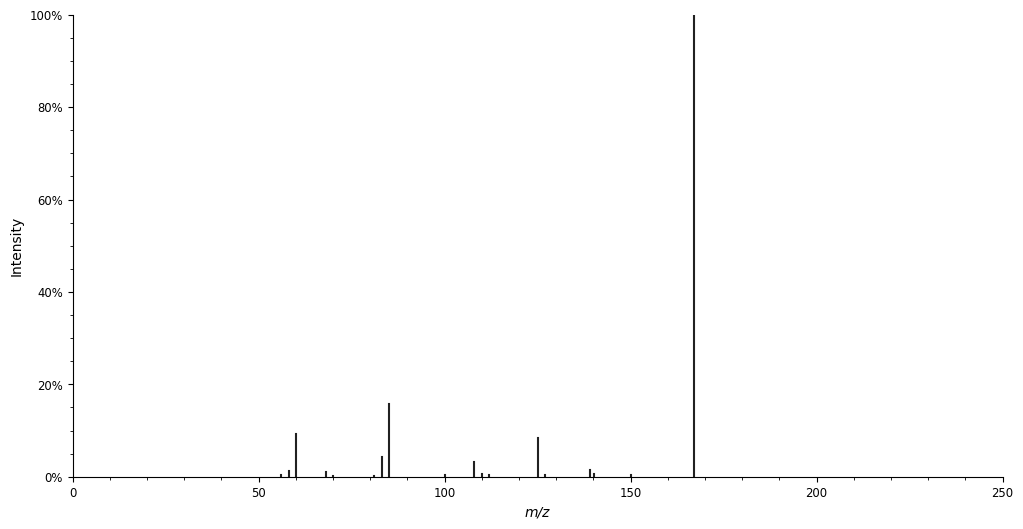

In [3]:
spectrums = mgfReader.read("/home/lbarbut/.vscode-server/data/CASMI_2016/CASMI2016_Cat2and3_Challenge_positive_mgf/Challenge-082.mgf", '\t')
print(spectrums[0])
spectrum01 = sv.plot_spectrum(spectrums[0])

Import Fiora Modules, Simulate a Spectrum For a Very Basic Molecule, Visualize

In [4]:
from fiora.GNN.GNNModules import GNNCompiler
from fiora.MS.SimulationFramework import SimulationFramework
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder

In [5]:
from fiora.MOL.Metabolite import Metabolite
from fiora.MOL.collision_energy import NCE_to_eV
import matplotlib.pyplot as plt

smiles ="CCCO"
model_path = "/home/lbarbut/pretrained_models/v0.0.1_merged_depth2.pt"
model = GNNCompiler.load_from_state_dict(model_path)
model.eval()
model = model.to("cuda:3")
meta = {"collision_energy":  NCE_to_eV(20, 52.03 + 1), 
                "instrument": "HCD", "name": "Alcohol", 'precursor_mode': "[M+H]+"}

def simulate_fiora(smiles, model, meta):
        metabolite = Metabolite(smiles)

        CE_upper_limit = 80.0
        weight_upper_limit = 800.0

        node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
        bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
        setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
        rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

        setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
        setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
        rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit
  

        fiora_run = SimulationFramework(model, True, True, dev="cuda:3")

        metabolite.create_molecular_structure_graph()
        metabolite.compute_graph_attributes(node_encoder, bond_encoder)
        metabolite.fragment_MOL()
        
        metabolite.add_metadata(meta, setup_encoder, rt_encoder)

        prediction = fiora_run.predict_metabolite_property(metabolite, model, as_batch=True)
        setattr(metabolite, "fragment_probs", prediction["fragment_probs"]) # metabolite.fragment_probs = prediction["fragment_probs"]
        simulated_spectrum = fiora_run.simulate_spectrum(metabolite, pred_label="fragment_probs")

        #print(simulated_spectrum)

        # formatted_sim_spectrum = {'peaks' : simulated_spectrum}
        # sv.plot_spectrum (formatted_sim_spectrum)
        # plt.ylim(0, 1.1)
        
        return simulated_spectrum, metabolite

simulate_fiora(smiles, model, meta)

({'mz': [61.064790875999996, 43.055324256],
  'intensity': [0.8145591020584106, 0.1850014626979828],
  'annotation': ['CCCO//[M+H]+', 'CCC//[M-H]+']},
 <Metabolite: CCCO>)

Richtige Lösung für Challenge 82 laden und Spektrum vorhersagen

In [6]:
correct_answers_df = pd.read_csv("/home/lbarbut/.vscode-server/data/CASMI_2016/solutions_casmi2016_cat2and3.csv")
challenge_82_answer = correct_answers_df[correct_answers_df['ChallengeName'] == 'Challenge-082']
challenge_82_answer

SourceFile  ChallengeName  PRECURSOR_MZ   ION_MODE     RT  nPeaks  \
81   XX845603  Challenge-082       167.104   POSITIVE  0.398      18   

          NAME                   SMILES  \
81  Cyromazine  NC1=NC(NC2CC2)=NC(N)=N1   

                                                INCHI  \
81  InChI=1S/C6H10N6/c7-4-10-5(8)12-6(11-4)9-3-1-2...   

                       INCHIKEY   CSID  PC_CID  
81  LVQDKIWDGQRHTE-UHFFFAOYSA-N  43550   47866

In [7]:
smiles = challenge_82_answer.iloc[0]["SMILES"]
meta = {
    "collision_energy":  NCE_to_eV(20, challenge_82_answer.iloc[0]["PRECURSOR_MZ"]),
    "instrument": "HCD", "name": challenge_82_answer.iloc[0]["NAME"], "precursor_mode": "[M+H]+"
}
challenge_82_answer_simulated_spectrum, simulated_metabolite = simulate_fiora(smiles, model, meta)
challenge_82_answer_simulated_spectrum, simulated_metabolite

({'mz': [167.10397031999997],
  'intensity': [0.9940675497055054],
  'annotation': ['Nc1nc(N)nc(NC2CC2)n1//[M+H]+']},
 <Metabolite: NC1=NC(NC2CC2)=NC(N)=N1>)

Cosinus Similarity between Challenge Spectrum and Prediction

In [8]:
from fiora.MS.spectral_scores import spectral_cosine
import numpy as np
challenge_82_spectrum = mgfReader.read("/home/lbarbut/.vscode-server/data/CASMI_2016/CASMI2016_Cat2and3_Challenge_positive_mgf/Challenge-082.mgf", '\t')
#challenge_82_spectrum[0]['peaks']

spectral_cosine(challenge_82_answer_simulated_spectrum, challenge_82_spectrum[0]['peaks'], transform=np.sqrt)   # sqrt to reduce the effect of the biggest peak

0.822117004246391

<Axes: xlabel='m/z', ylabel='Intensity'>

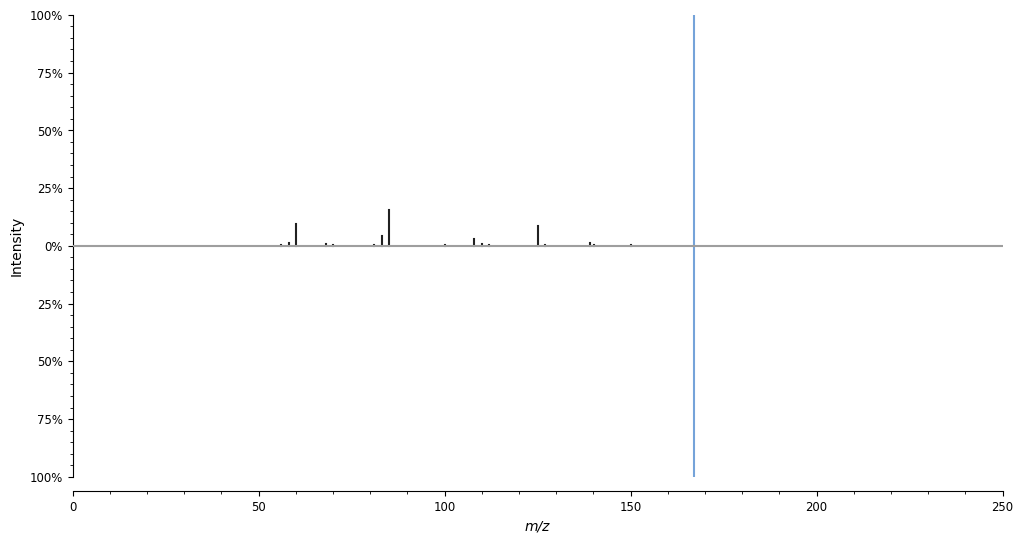

In [9]:
sv.plot_spectrum(challenge_82_spectrum[0], {'peaks' : challenge_82_answer_simulated_spectrum}, highlight_matches=True)  # compare the spectrum, which is the challenge input to spectrum, which is the fiora output


Load All Candidates for Challenge 82 and Predict The First 20, Cosine Similarity of Candidates - Histogram, Where is The Correct Answer

In [10]:
challenge_82_candidates = pd.read_csv("/home/lbarbut/.vscode-server/data/CASMI2016_Cat2and3_Challenge_Candidates (1)/Challenge-082.csv")
# challenge_82_candidates_20_rows = challenge_82_candidates.head(20)
# predict 20 spectrums
cnt = 0
for i, row in challenge_82_candidates.iterrows():
    if cnt >= 20:
        break
    # print(row)
    smiles = row["SMILES"]  # SMILES Strings with a '.' in them are problematic
    model_path = "/home/lbarbut/pretrained_models/v0.0.1_merged_depth2.pt"
    meta = {
        "collision_energy":  NCE_to_eV(20, row["MonoisotopicMass"]),
        "instrument": "HCD", "name": row["CompoundName"], "precursor_mode": "[M+H]+"
    }
    try:
        c82_simulated_spectrum, c82_simulated_metabolite = simulate_fiora(smiles, model_path, meta)
        score = spectral_cosine(c82_simulated_spectrum, challenge_82_spectrum[0]['peaks'], transform=np.sqrt)
        challenge_82_candidates.at[i, "Score"] = score
        cnt = cnt + 1
    except:
        continue

ERROR (0, 1) [10] [10Na+]
ERROR (0, 1) [10] [10Na+]
ERROR (0, 1) [10] [10Na+]
ERROR (0, 1) [10] [10Na+]


[12:02:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


ERROR (1, 2) [0] [Li+]
ERROR (1, 2) [0] [Li+]
ERROR (0, 1) [10] [10Na+]
ERROR (0, 1) [10] [10Na+]
ERROR (0, 1) [10] [10Na+]
ERROR (3, 5) [6, 7, 8, 9, 10, 11] [11NH2][9c]1[8n][7cH][6cH][10nH]1


[12:02:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[12:02:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[12:02:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 8 9
[12:02:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[12:02:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[12:02:39] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6 7 8
[12:02:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[12:02:39] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[12:02:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


In [11]:
# how to iterate every row and save the cosine similarity scores as a new column 

# for i, row in challenge_82_candidates_first_20_rows.iterrows():
#     challenge_82_candidates_first_20_rows.at[i, "score"] = 1.0


In [12]:
import matplotlib.pyplot as plt
from fiora.MS.spectral_scores import cosine_bias
from fiora.MS.spectral_scores import spectral_reflection_cosine
from fiora.MS.spectral_scores import reweighted_dot

# def visualize_challenge(df):
    
#     scores = df["Score"].dropna()
#     compound_names = df.loc[~df["Score"].isna(), "CompoundName"]
    
#     colors = ['lightblue' if name != 'Cyromazine' else 'green' for name in compound_names]

#     plt.barh(compound_names, scores, color = colors, edgecolor="k")
#     plt.xlabel("Scores")
#     plt.ylabel("Compound Names")
#     plt.title("Scores by Compound Names")
#     plt.xticks(rotation=0)

#     for i, score in enumerate(scores):
#         plt.text(score, i, f"{score:.3f}", ha="right", va="center")

#     plt.show()
    
# visualize_challenge(challenge_82_candidates)

===========================================================================================

Load All Challenges and All Candidates, Automate the Prediction Steps with Pandas DataFrame and SimulationFramework.simulate_all

In [13]:
# Load Positive Challenges (mgf)
all_positive_challenges = mgfReader.read("/home/lbarbut/.vscode-server/data/CASMI_2016/CASMI2016_Cat2and3_Challenge_positive_mgf/all_positive.mgf", '\t')
# all_positive_challenges[2]

# Load Candidates (csv)
positive_candidate_dfs = []
for i in range (82, 209):
    if i < 100:
        candidate_df = pd.read_csv(f"/home/lbarbut/.vscode-server/data/CASMI2016_Cat2and3_Challenge_Candidates (1)/Challenge-0{i}.csv")
    else:
        candidate_df = pd.read_csv(f"/home/lbarbut/.vscode-server/data/CASMI2016_Cat2and3_Challenge_Candidates (1)/Challenge-{i}.csv")
    positive_candidate_dfs.append(candidate_df)
# positive_candidate_dfs

In [14]:
for i in range(len(positive_candidate_dfs)):
    positive_candidate_dfs[i] = positive_candidate_dfs[i][~positive_candidate_dfs[i]["SMILES"].str.contains('\.')]


In [15]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [16]:
model_path = "/home/lbarbut/pretrained_models/v0.0.1_merged_depth2.pt"

model = GNNCompiler.load_from_state_dict(model_path)
model.eval()
model = model.to("cuda:3")

for j in range (0, len(positive_candidate_dfs)):
    positive_candidate_dfs[j]["Score"] = [{} for i in range(len(positive_candidate_dfs[j]))]
    positive_candidate_dfs[j]["Spectrum"] = [{} for i in range(len(positive_candidate_dfs[j]))]
    print("Loop Count: " + str(j))
    scores_dict = []
    for i, row in positive_candidate_dfs[j].iterrows():
        # print(row)
        smiles = row["SMILES"]  # SMILES Strings with a '.' in them are problematic
        meta = {
            "collision_energy":  NCE_to_eV(35, (row["MonoisotopicMass"] + 1)),
            "instrument": "HCD", "name": row["CompoundName"], "precursor_mode": "[M+H]+"
        }
        try:
            simulated_spectrum, metabolite = simulate_fiora(smiles, model, meta)
            metabolite.match_fragments_to_peaks(all_positive_challenges[j]['peaks']['mz'], all_positive_challenges[j]['peaks']['intensity'])
            
            positive_candidate_dfs[j].at[i, "ExactMolMass"] = metabolite.ExactMolWeight
            positive_candidate_dfs[j].at[i, "CollisionEnergy"] = meta["collision_energy"]
            positive_candidate_dfs[j].at[i, "PrecursorProbability"] = metabolite.match_stats["precursor_prob"]
            positive_candidate_dfs[j].at[i, "Coverage"] = metabolite.match_stats["coverage"]
            positive_candidate_dfs[j].at[i, "Spectrum"] = simulated_spectrum

            score_cosine, cosine_bias = spectral_cosine(simulated_spectrum, all_positive_challenges[j]['peaks'], transform=np.sqrt, with_bias=True)
            score_reflection = spectral_reflection_cosine(simulated_spectrum, all_positive_challenges[j]['peaks'], transform=np.sqrt)
            score_reweighted, reweighted_bias = reweighted_dot(simulated_spectrum,  all_positive_challenges[j]['peaks'], int_pow=0.5, mz_pow=0.5, with_bias=True)
            scores_dict.append({
                "cosine": {"score": score_cosine, "bias": cosine_bias},
                "reflection": {"score": score_reflection, "bias": None},
                "reweighted": {"score": score_reweighted, "bias": reweighted_bias}
            })
            
            # print(scores_dict[-1])
            positive_candidate_dfs[j].at[i, "Score"] = scores_dict[-1]
            if j < 18:
                positive_candidate_dfs[j]["Challenge"] = f"Challenge-0{j + 82}"
            else:
                positive_candidate_dfs[j]["Challenge"] = f"Challenge-{j + 82}"
            
        except Exception as e:
            print(e)
            continue


Loop Count: 0
Loop Count: 1
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 2
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 3
Loop Count: 4
Loop Count: 5


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 6
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 7
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 8
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signatur

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 12
Loop Count: 13
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 14
Loop Count: 15
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not 

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Loop Count: 16
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 19
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 26
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 29
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 33
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 34
Loop Count: 35
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 36
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not 

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 40


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 41
Loop Count: 42
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcE

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 44
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 45
Loop Count: 46
Loop Count: 47
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 48


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 51
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 53
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 54
Loop Count: 55
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signa

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 60
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 61
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 62
Loop Count: 63
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcE

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 78
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 79
Loop Count: 80


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 81
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 82
Loop Count: 83
Loop Count: 84
Loop Count: 85
Loop Count: 86


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 87
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 88
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcE

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 94
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 97
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 98


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 99
Loop Count: 100
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    Calc

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 111
Loop Count: 112
Loop Count: 113
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ si

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 114
Loop Count: 115
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    Cal

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 117
Loop Count: 118
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 119
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ si

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 120


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/tmp/ipykernel_2704430/3716659930.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_candidate_dfs[j]["Score"] = [{} for i in range(len(positive_candidate_dfs[j]))]
/tmp/ipykernel_2704430/3716659930.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_candidate_dfs[j]["Spectrum"] = [{} for i in range(len(positive_candidate_dfs[j]))]
/tmp/ipykernel_2704430/3716659930.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Loop Count: 126


In [17]:
positive_candidate_dfs[0]

Identifier                                       CompoundName  \
2        43550                                         Cyromazine   
5       235471  6-Amino-N'-ethyl-1,2,4-triazine-5-carboximidamide   
6       262957    1-Methyl-N-(2H-tetrazol-5-yl)-2-pyrrolidinimine   
7       363141      1-(2-Hydrazino-2-oxoethyl)-4-methylpyridinium   
8       383171            1-Ethyl-4-(hydrazinocarbonyl)pyridinium   
9       385528  1-(4,5-Dihydro-1H-imidazol-2-yl)-1H-pyrazole-3...   
10      497651          1-(Carbamoylamino)-3,5-dimethylpyridinium   
11     1439915                 2-(Isonicotinoylamino)ethanaminium   
12     2041529                           1,1,2-Trifluoro-1-octene   
13     2062282    4-CYCLOPROPYL-6-HYDRAZINO-1,3,5-TRIAZIN-2-AMINE   
14     2856608         Imino[(4-methoxyphenyl)amino]methanaminium   
15     3544002             1-(2-Aminoethyl)-3-carbamoylpyridinium   
16     3627513       5-(2-Cyclopentylidenehydrazino)-2H-tetrazole   
17     4411424  3a,4,8a,9-Tetrahydro-3H,8H-bis[1,2,3]triazolo[...   
18     4532969  7-Hydrazino-5-methyl-1,7-dihydro[1,2,4]triazol...   
19     4577773                         2-Octene, 1,1,2-trifluoro-   
20     5378403         2-[(3-Pyridinylcarbonyl)amino]ethanaminium   
21     5381024           Diamino-N-(3-methoxyphenyl)methaniminium   
22     5615239         2-[(2-Pyridinylcarbonyl)amino]ethanaminium   
23     8279040                Ethyl 4-methyl(2,6-~2~H_2_)benzoate   
24     8279041                 4-Phenyl(4,4-~2~H_2_)butanoic acid   
25     8283946  (7R)-2,7-Dimethyl-5-oxo-5,6,7,8-tetrahydroimid...   
26     8686656                   Phenyl(~2~H_2_)methyl propionate   
27     9183468                           8,8,8-Trifluoro-1-octene   
28     9205349  (1Z)-2-Hydroxy-4-(2-vinyl-1-aziridinyl)-1-bute...   
29     9259387                     (1R,2R)-1,2-Diazidocyclohexane   
32     9644103  1-Allyl-2-hydroxy-1,4,5,6-tetrahydro-3-pyridin...   
33    10277448                   4-Ethyl-1,1,1-trifluoro-3-hexene   
34    10325500      trans-1-Methyl-4-(trifluoromethyl)cyclohexane   
35    10329630                      (2E)-1,1,1-Trifluoro-2-octene   
36    10555019  1-[(2E)-2-(Hydroxyimino)ethyl]-2-(methylamino)...   
37    10593687           N~2~-Allyl-1,3,5-triazine-2,4,6-triamine   
40    21413968                             1,1-Diazidocyclohexane   
43    23210302            1,5,6,7-Tetrahydro-2,4-pteridinediamine   
44    23976553       1-(4-Methoxyphenyl)-1-(2,2-~2~H_2_)propanone   
45    24818618              1-[2-(Carbamoylamino)ethyl]pyridinium   
46    25039347  1-Allyl-4-[(E)-(hydroxyimino)methyl]-3-methyl-...   
47    25072127     1',5'-Dihydro-4'H-1,4'-bipyrazole-4,4'-diamine   
48    25072128  1',5'-Dihydro-1H,4'H-3,4'-bipyrazole-4,4'-diamine   
49    32748351  (2E)-1-Methyl-N-(1H-tetrazol-5-yl)-2-pyrrolidi...   
50    35141708                           1,1,1-Trifluoro-2-octene   
51    35490792  4-(Aminomethyl)-6-methyl-1,6-dihydropyrazolo[3...   
52    35909103  3-[5-Amino-3-(methylamino)-1H-1,2,4-triazol-1-...   
53    35914361  5-[(2-Propyn-1-ylamino)methyl]-4H-1,2,4-triazo...   
54    37494071  1-(3,5-Dimethyl-3H-imidazo[1,2-d]tetrazol-6-yl...   
55    37494072  1-(5-Methyl-3H-imidazo[1,2-d]tetrazol-6-yl)eth...   
56    37552771  5,6,7,8-Tetrahydro[1,2,4]triazolo[4,3-a]pyrazi...   
57    37662917  2-(5,6-Dihydro-4H-imidazo[1,2-b][1,2,4]triazol...   
58    37664172  4-Methyl-5,6-dihydro-4H-imidazo[1,2-b][1,2,4]t...   
59    40247223  3-[Methyl(1-methyl-1H-tetrazol-5-yl)amino]prop...   
60    40274262  N-(1H-Tetrazol-5-ylmethyl)cyclopropanecarboxim...   
61    41386778  5-(1-Amino-3-butyn-1-yl)-4H-1,2,4-triazole-3,4...   
62    41946734  (2E)-2-[(1-Methyl-1H-pyrazol-5-yl)methylene]hy...   
63    41976095  N-(4H-1,2,4-Triazol-3-ylmethyl)-4,5-dihydro-1H...   

    MonoisotopicMass MolecularFormula                              SMILES  \
2         166.096695          C6H10N6                C1CC1Nc2nc(nc(n2)N)N   
5         166.096695          C6H10N6              CC/

simulate_all

In [18]:
import logging

# model_path = "/home/lbarbut/pretrained_models/v0.0.1_merged_depth2.pt"

# CE_upper_limit = 80.0
# weight_upper_limit = 800.0

# node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
# bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
# setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
# rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

# setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
# setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
# rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit

# model = GNNCompiler.load_from_state_dict(model_path)
# model.eval()
# model = model.to("cuda:3")

# fiora_run = SimulationFramework(model, True, True, dev="cuda:3")

# pos_cand_score_df = []

# for j in range (0, len(positive_candidate_dfs)):
#     print("Loop Count: " + str(j))
    
#     positive_candidate_dfs[j]["peaks"] = [{} for i in range(len(positive_candidate_dfs[j]))]
    
#     for i, row in positive_candidate_dfs[j].iterrows():     # ein candidate DF
#         try:
#             meta = {
#                 "collision_energy":  NCE_to_eV(35, (row["MonoisotopicMass"] + 1)),
#                 "instrument": "HCD", "name": row["CompoundName"], "precursor_mode": "[M+H]+"
#             }       
#             metabolite = Metabolite(row["SMILES"])
#             metabolite.create_molecular_structure_graph()
#             metabolite.compute_graph_attributes(node_encoder, bond_encoder)
#             metabolite.fragment_MOL()
#             metabolite.add_metadata(meta, setup_encoder, rt_encoder)
            
#             positive_candidate_dfs[j].at[i, "Metabolite"] = metabolite
#             positive_candidate_dfs[j].at[i, "peaks"] = all_positive_challenges[j]["peaks"]
#             positive_candidate_dfs[j] = positive_candidate_dfs[j].dropna(subset=["Metabolite"])
            
#         except Exception as e:
#             continue
     
#     try:    
#         pos_cand_score_df.append(fiora_run.simulate_all(df=positive_candidate_dfs[j], model=model))
#         print("simulate all success")
        
#     except Exception as e:
#         print(positive_candidate_dfs[j])
#         continue
            


Combine the Challenge DataFrames by Concatenate and Group By Challenge

In [19]:
combined_positive_challenges_df = pd.concat(positive_candidate_dfs, axis=0)
# combined_challenges_df

# positive_grouped_df = combined_positive_challenges_df.groupby("Challenge")

Visualize Challenge82 (Cosine Score Density of Solution vs. Other Candidates)

In [20]:
# def visualize_challenge_score_dict(df):
#     scores = []
#     compound_names = []
#     for i, row in df.iterrows():
#         try:
#             cosine_score = row["spectral_sqrt_cosine"]
#             # print(cosine_score)
#             compound_name = row["CompoundName"]
#             # print(compound_name)
#             scores.append(cosine_score)
#             compound_names.append(compound_name)
#         except:
#             continue
        
#     # automate
#     colors = ['lightblue' if name != 'Cyromazine' else 'green' for name in compound_names]

#     plt.barh(compound_names, scores, color = colors, edgecolor="k")
#     plt.xlabel("Scores")
#     plt.ylabel("Compound Names")
#     plt.title("Scores by Compound Names")
#     plt.xticks(rotation=0)

#     for i, score in enumerate(scores):
#         plt.text(score, i, f"{score:.3f}", ha="right", va="center")

#     plt.show()

# visualize_challenge_score_dict(pos_cand_score_df[0])

In [21]:
positive_candidate_dfs[0].at[2, "Spectrum"]      # Idea: while drawing molecules show the fragmentation points

{'mz': [167.10397031999997, 127.07267019199999],
 'intensity': [0.9743973016738892, 0.011615595780313015],
 'annotation': ['Nc1nc(N)nc(NC2CC2)n1//[M+H]+', 'Nc1nc(N)nc(N)n1//[M+H]+'],
 'mz_int': [12.76031573977704, 1.2149175987182432]}

Vergleich pos/neg Spectra, Cosine Score der Lösungen miteinander Vergleich (z.B. Boxplot)

In [22]:
# Load Negative Challenges (mgf)
all_negative_challenges = mgfReader.read("/home/lbarbut/.vscode-server/data/CASMI_2016/CASMI2016_Cat2and3_Challenge_negative_mgf/all_negative.mgf", '\t')
# all_negative_challenges[2]

# Load Candidates (csv)
negative_candidate_dfs = []
for i in range (1, 82):
    if i < 10:
        candidate_df = pd.read_csv(f"/home/lbarbut/.vscode-server/data/CASMI2016_Cat2and3_Challenge_Candidates (1)/Challenge-00{i}.csv")
    else:
        candidate_df = pd.read_csv(f"/home/lbarbut/.vscode-server/data/CASMI2016_Cat2and3_Challenge_Candidates (1)/Challenge-0{i}.csv")
    negative_candidate_dfs.append(candidate_df)
# positive_candidate_dfs

In [23]:
for i in range(len(negative_candidate_dfs)):
    negative_candidate_dfs[i] = negative_candidate_dfs[i][~negative_candidate_dfs[i]["SMILES"].str.contains('\.')]


In [24]:

for j in range (0, len(negative_candidate_dfs)):
    negative_candidate_dfs[j]["Score"] = [{} for i in range(len(negative_candidate_dfs[j]))]    # problematic, use .loc
    negative_candidate_dfs[j]["Spectrum"] = [{} for i in range(len(negative_candidate_dfs[j]))]
    print("Loop Count: " + str(j))
    scores_dict = []
    for i, row in negative_candidate_dfs[j].iterrows():
        # print(row)
        smiles = row["SMILES"]  # SMILES Strings with a '.' in them are problematic
        # model_path = "/home/lbarbut/pretrained_models/v0.0.1_merged_depth2.pt"
        meta = {
            "collision_energy":  NCE_to_eV(35, (row["MonoisotopicMass"] - 1)),
            "instrument": "HCD", "name": row["CompoundName"], "precursor_mode": "[M-H]-"
        }
        try:
            simulated_spectrum, metabolite = simulate_fiora(smiles, model, meta)
            metabolite.match_fragments_to_peaks(all_negative_challenges[j]['peaks']['mz'], all_negative_challenges[j]['peaks']['intensity']) 
            
            negative_candidate_dfs[j].at[i, "Spectrum"] = simulated_spectrum
            negative_candidate_dfs[j].at[i, "ExactMolMass"] = metabolite.ExactMolWeight
            negative_candidate_dfs[j].at[i, "CollisionEnergy"] = meta["collision_energy"]
            negative_candidate_dfs[j].at[i, "PrecursorProbability"] = metabolite.match_stats["precursor_prob"]
            negative_candidate_dfs[j].at[i, "Coverage"] = metabolite.match_stats["coverage"]
            
            score_cosine, cosine_bias = spectral_cosine(simulated_spectrum, all_negative_challenges[j]['peaks'], transform=np.sqrt, with_bias=True)
            score_reflection = spectral_reflection_cosine(simulated_spectrum, all_negative_challenges[j]['peaks'], transform=np.sqrt)
            score_reweighted, reweighted_bias = reweighted_dot(simulated_spectrum,  all_negative_challenges[j]['peaks'], int_pow=0.5, mz_pow=0.5, with_bias=True)
            scores_dict.append({
                "cosine": {"score": score_cosine, "bias": cosine_bias},
                "reflection": {"score": score_reflection, "bias": None},
                "reweighted": {"score": score_reweighted, "bias": reweighted_bias}
            })
            # print(scores_dict[-1])
            
            negative_candidate_dfs[j].at[i, "Score"] = scores_dict[-1]
            if j < 9:
                negative_candidate_dfs[j]["Challenge"] = f"Challenge-00{j + 1}"
            elif j < 99:
                negative_candidate_dfs[j]["Challenge"] = f"Challenge-0{j + 1}"
            else:
                negative_candidate_dfs[j]["Challenge"] = f"Challenge-{j + 1}"
            
        except Exception as e:
            print(e)
            continue

Loop Count: 0


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 1


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 2


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 3


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 4


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 6


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 7


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 8


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 9


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Loop Count: 10


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 14


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 15


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 17
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 18


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 20


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 22


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 25


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 26


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 27


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 28


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 29


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 31


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 32


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Loop Count: 33


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 35


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Loop Count: 36


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 37


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 38


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 39


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 40


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 45


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 46


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 47


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 48


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 49


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 51


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 52


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 54


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 55


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 57


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 58


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 60


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 61


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Loop Count: 62


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 63


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:116: RuntimeWarning: invalid value encountered in power
  spec["mz_int"] = [np.power(spec["intensity"][i], int_pow)*np.power(mz, mz_pow) for i, mz in enumerate(spec["mz"])]


Loop Count: 64


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bo

/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 66


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 67
Loop Count: 68


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 69


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 70


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 71


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 72
Loop Count: 73


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 74


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Loop Count: 75


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 76


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 77


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 78


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Loop Count: 79


/home/lbarbut/fiora/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))


Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)


/tmp/ipykernel_2704430/394357628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_candidate_dfs[j]["Score"] = [{} for i in range(len(negative_candidate_dfs[j]))]    # problematic, use .loc
/tmp/ipykernel_2704430/394357628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_candidate_dfs[j]["Spectrum"] = [{} for i in range(len(negative_candidate_dfs[j]))]
/tmp/ipykernel_2704430/394357628.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

Loop Count: 80


In [25]:
negative_candidate_dfs[3]

Identifier                                       CompoundName  \
0        11266                             m-Dichloronitrobenzene   
1        11567                        1,3-Dichloro-5-nitrobenzene   
2        14797                                         Clopyralid   
3        85563                      2,6-Dichloroisonicotinic acid   
4       190735             3,5-Dichloro-2-pyridinecarboxylic acid   
5       217109                         5,6-Dichloronicotinic acid   
6       277298                         4,5-dichloropicolinic acid   
7       526562                      3,5-DICHLOROISONICOTINIC ACID   
8       713855                         4,6-Dichloronicotinic acid   
9       746430                         2,6-Dichloronicotinic acid   
10     1217955         3,5-Dichloro-1H-pyrrole-2,4-dicarbaldehyde   
11     2017679  3,6-Dichloro-4-oxo-1,4-dihydro-2-pyridinecarba...   
12     2017761                      2,3-Dichloroisonicotinic acid   
13     2017763                         2,5-Dichloronicotinic acid   
14     2017765                      2,5-Dichloroisonicotinic acid   
15     2017766             3,4-Dichloro-2-pyridinecarboxylic acid   
16     2017767                         4,5-Dichloronicotinic acid   
17     2043684           2,6-Dichloro-3-hydroxyisonicotinaldehyde   
18     8256812  (2E)-3-(3-Chloro-1,2-oxazol-5-yl)acryloyl chlo...   
19     8759263                         2,4-Dichloronicotinic acid   
20     9096598         3,4-Dichloro-1H-pyrrole-2,5-dicarbaldehyde   
21     9249382  (3Z)-5-(Methylsulfanyl)-3-(nitrosomethylene)-3...   
22    10526471             5,6-Dichloro-2-pyridinecarboxylic acid   
23    10594749  5-[(1Z)-N-Hydroxyethanimidoyl]-3H-1,2-dithiole...   
24    10594759  5-[(Z)-(Hydroxyimino)methyl]-4-methyl-3H-1,2-d...   
25    13222342                         4,6-dichloropicolinic acid   
26    14569081              5-Chloro-6-hydroxynicotinoyl chloride   
27    21106035                           2,4-Dichloronitrobenzene   
28    21106095                        1,2-Dichloro-4-nitrobenzene   
29    21106574                               dichloronitrobenzene   
30    21111865                        1,4-Dichloro-2-nitrobenzene   
31    22752132                       2,5-Dichloro-4-nitrosophenol   
32    23255083  5-[(Hydroxyimino)methyl]-4-methyl-3H-1,2-dithi...   
33    23978508  5-Chloro-2-oxo-1,2-dihydro-3-pyridinecarbonyl ...   
34    24187498                2-Chloronicotinoyl chloride 1-oxide   
35    26553560               1H-Pyrrole-3,4-dicarbonyl dichloride   
36    37054317             5-Chloro-3-pyridinyl carbonochloridate   

    MonoisotopicMass MolecularFormula                          SMILES  \
0         190.954086       C6H3Cl2NO2  c1cc(c(c(c1)Cl)[N+](=O)[O-])Cl   
1         190.954086       C6H3Cl2NO2    c1c(cc(cc1Cl)Cl)[N+](=O)[O-]   
2         190.954086       C6H3Cl2NO2          c1cc(nc(c1Cl)C(=O)O)Cl   
3         190.954086       C6H3Cl2NO2          c1c(cc(nc1Cl)Cl)C(=O)O   
4         190.954086       C6H3Cl2NO2          c1c(cnc(c1Cl)C(=O)O)Cl   
5         190.954086       C6H3Cl2NO2          c1c(cnc(c1Cl)Cl)C(=O)O   
6         190.954086       C6H3Cl2NO2          c1c(c(cnc1C(=O)O)Cl)Cl   
7         190.954086       C6H3Cl2NO2        c1c(c(c(cn1)Cl)C(=O)O)Cl   
8         190.954086       C6H3Cl2NO2          c1c(c(cnc1Cl)C(=O)O)Cl   
9         190.954086       C6H3Cl2NO2          c1cc(nc(c1C(=O)O)Cl)Cl   
10        190.954086       C6H3Cl2NO2      C(=O)c1c(c([nH]c1Cl)C=O)Cl   
11        190.954086       C6H3Cl2NO2      c1c(=O)c(c([nH]c1Cl)C=O)Cl   
12        190.954086       C6H3Cl2NO2          c1cnc(c(c1C(=O)O)Cl)Cl   
13        190.954086       C6H3Cl2NO2          c1c(cnc(c1C(=O)O)Cl)Cl   
14        190.954086       C6H3Cl2NO2          c1c(c(cnc1Cl)Cl)C(=O)O   
15        190.954086       C6H3Cl2NO2          c1cnc(c(c1Cl)Cl)C(=O)O   
16        190.954086       C6H3Cl2NO2        c1c(c(c(cn1)Cl)Cl)C(=O)O   
17        190.954086       C6H3Cl2NO2          c1c(c(c(nc1Cl)Cl)O)C

In [26]:
combined_negative_challenges_df = pd.concat(negative_candidate_dfs, axis=0)
combined_negative_challenges_df

# negative_grouped_df = combined_negative_challenges_df.groupby("Challenge")

Identifier                                       CompoundName  \
0          6415                 1-Amino-2-naphthalenesulfonic acid   
1          6418                 2-Amino-1-naphthalenesulfonic acid   
2          6466                    1-naphthylamine-8-sulfonic acid   
3          6532                                   Naphthionic acid   
4          6535                    1-naphthylamine-5-sulfonic acid   
..          ...                                                ...   
172    35430594  4-(4-Cyclopropyl-1H-1,2,3-triazol-1-yl)-1-(4-f...   
173    35775034  {2-Methyl-6-[(trimethylsilyl)oxy]-2,5-cyclohex...   
174    35775035  {2-Methyl-5-[(trimethylsilyl)oxy]-2,5-cyclohex...   
175    35775037  {2-Methyl-3-[(trimethylsilyl)oxy]-2,5-cyclohex...   
176    35804370  (2Z)-2-[1-(Diphenylphosphino)-3,3-dimethyl-2-b...   

     MonoisotopicMass MolecularFormula  \
0          223.030319        C10H9NO3S   
1          223.030319        C10H9NO3S   
2          223.030319        C10H9NO3S   
3          223.030319        C10H9NO3S   
4          223.030319        C10H9NO3S   
..                ...              ...   
172        326.190674        C19H23FN4   
173        326.191742       C16H34OSi3   
174        326.191742       C16H34OSi3   
175        326.191742       C16H34OSi3   
176        326.191193        C20H27N2P   

                                                SMILES  \
0                        c1ccc2c(c1)ccc(c2N)S(=O)(=O)O   
1                        c1ccc2c(c1)ccc(c2S(=O)(=O)O)N   
2                        c1cc2cccc(c2c(c1)N)S(=O)(=O)O   
3                        c1ccc2c(c1)c(ccc2S(=O)(=O)O)N   
4                        c1cc2c(cccc2S(=O)(=O)O)c(c1)N   
..                                                 ...   
172            c1cc(ccc1C=CCN2CCC(CC2)n3cc(nn3)C4CC4)F   
173  CC1=CC(C=C(C1[Si](C)(C)C)O[Si](C)(C)C)[Si](C)(C)C   
174  CC1=CC(C(=CC1[Si](C)(C)C)O[Si](C)(C)C)[Si](C)(C)C   
175  CC1=C(C(C=CC1[Si](C)(C)C)[Si](C)(C)C)O[Si](C)(C)C   
176          CC(C)(C)/C(=N/N(C)C)/CP(c1ccccc1)c2ccccc2   

                                                 InChI  \
0    InChI=1S/C10H9NO3S/c11-10-8-4-2-1-3-7(8)5-6-9(...   
1    InChI=1S/C10H9NO3S/c11-9-6-5-7-3-1-2-4-8(7)10(...   
2    InChI=1S/C10H9NO3S/c11-8-5-1-3-7-4-2-6-9(10(7)...   
3    InChI=1S/C10H9NO3S/c11-9-5-6-10(15(12,13)14)8-...   
4    InChI=1S/C10H9NO3S/c11-9-5-1-4-8-7(9)3-2-6-10(...   
..                                                 ...   
172  InChI=1S/C19H23FN4/c20-17-7-3-15(4-8-17)2-1-11...   
173  InChI=1S/C16H34OSi3/c1-13-11-14(18(2,3)4)12-15...   
174  InChI=1S/C16H34OSi3/c1-13-11-16(19(5,6)7)14(17...   
175  InChI=1S/C16H34OSi3/c1-13-14(18(2,3)4)11-12-15...   
176  InChI=1S/C20H27N2P/c1-20(2,3)19(21-22(4)5)16-2...   

                        InChIKey  \
0    ONZWNZGVZFLMNZ-UHFFFAOYSA-N   
1    GWIAAIUASRVOIA-UHFFFAOYSA-N   
2    CYJJLCDCWVZEDZ-UHFFFAOYSA-N   
3    NRZRRZAVMCAKEP-UHFFFAOYSA-N   
4    DQNAQOYOSRJXFZ-UHFFFAOYSA-N   
..                           ...   
172  ZBLPJZUZTDETPY-UHFFFAOYSA-N   
173  WYHBJQJDKWTIBW-UHFFFAOYSA-N   
174  GMIIJHAIBZMGKM-UHFFFAOYSA-N   
175  ZDAQMTBEODTVTA-UHFFFAOYSA-N   
176  KSVFCMWWWHGCML-XUTLUUPISA-N   

                                                 Score  \
0    {'cosine': {'score': 0.0, 'bias': 1.0}, 'refle...   
1    {'cosine': {'score': 0.0, 'bias': 1.0}, 'refle...   
2    {'cosine': {'score': 0.0, 'bias': 1.0}, 'refle...   
3    {'cosine': {'score': 0.0, 'bias': 1.0}, 'refle...   
4    {'cosine': {'score': 0.0, 'bias': 1.0}, 'refle...   
..                                                 ...   
172  {'cosine': {'score': 0.0, 'bias': 1.0}, 'refle...   
173  {'cosine': {'score': 0.0, 'bias': 1.0}, 'refle...   
174  {'cosine': {'score': 0.0, 'bias': 1.0}, 'refle...   
175  {'cosine': {'score': 0.0, 'bias': 1.0}, 'refle...   
176  {'cosine': {'score': 0.10608227488694319, 'bia...   

                                              Spectrum  ExactMolMass  \
0    {'mz': [224.037590148, 142.066223288, 79.95791...    223.0

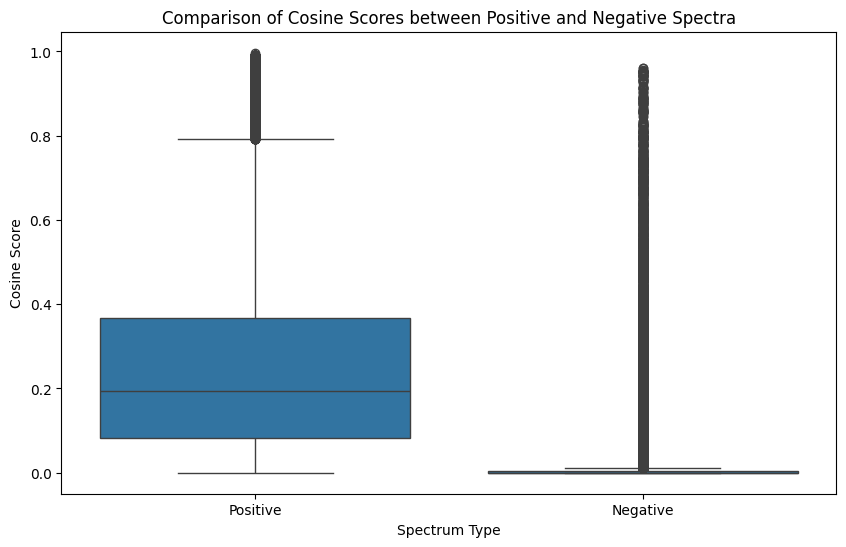

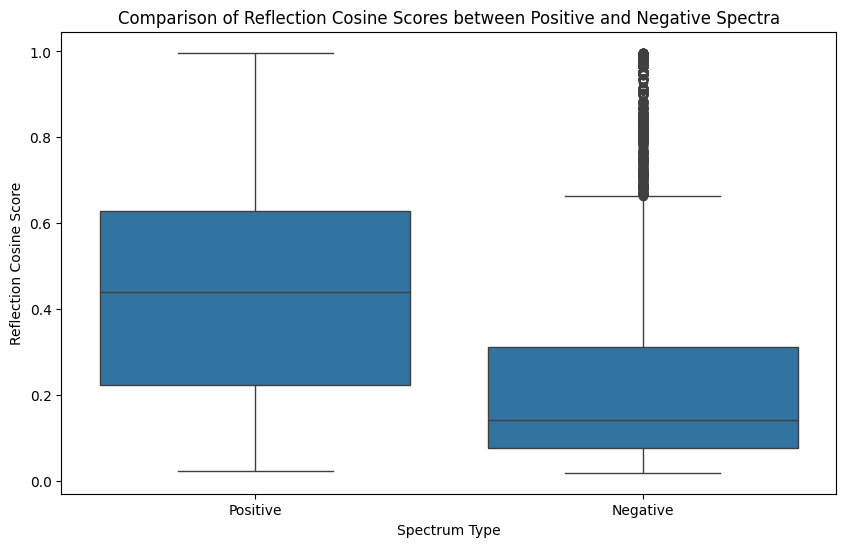

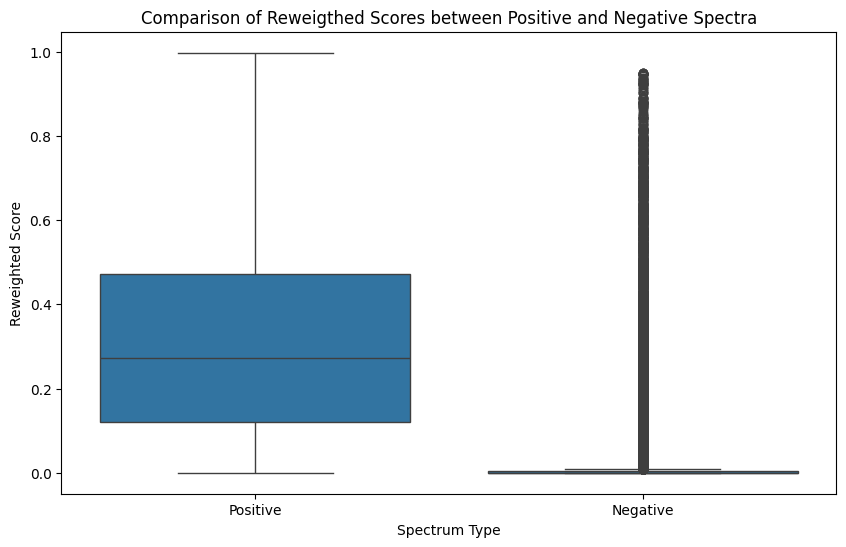

In [27]:
import seaborn as sns

combined_positive_challenges_df["SpectrumType"] = "Positive"
combined_negative_challenges_df["SpectrumType"] = "Negative"
pos_neg_combine_df = pd.concat([combined_positive_challenges_df, combined_negative_challenges_df], ignore_index=True)
pos_neg_combine_df.dropna(subset=["Score"], inplace=True)
pos_neg_combine_df["CosineScore"] = pos_neg_combine_df["Score"].apply(lambda x: np.nan if x == {} else x["cosine"]["score"])
pos_neg_combine_df["ReflCosineScore"] = pos_neg_combine_df["Score"].apply(lambda x: np.nan if x == {} else x["reflection"]["score"])
pos_neg_combine_df["ReweightedScore"] = pos_neg_combine_df["Score"].apply(lambda x: np.nan if x == {} else x["reweighted"]["score"])

# Visualize with Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="SpectrumType", y="CosineScore", data=pos_neg_combine_df)
plt.xlabel("Spectrum Type")
plt.ylabel("Cosine Score")
plt.title("Comparison of Cosine Scores between Positive and Negative Spectra")
plt.show()

# for other Scores
plt.figure(figsize=(10, 6))
sns.boxplot(x="SpectrumType", y="ReflCosineScore", data=pos_neg_combine_df)
plt.xlabel("Spectrum Type")
plt.ylabel("Reflection Cosine Score")
plt.title("Comparison of Reflection Cosine Scores between Positive and Negative Spectra")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="SpectrumType", y="ReweightedScore", data=pos_neg_combine_df)
plt.xlabel("Spectrum Type")
plt.ylabel("Reweighted Score")
plt.title("Comparison of Reweigthed Scores between Positive and Negative Spectra")
plt.show()

Scatterplots um Zusammenhänge Zwischen Versch. Scores/Variable zu Beschreiben, cosine vs bias, cosine vs collision energy, cosine vs ExactMolMass, Cosine vs Precursor_Probability, Cosine vs Coverage

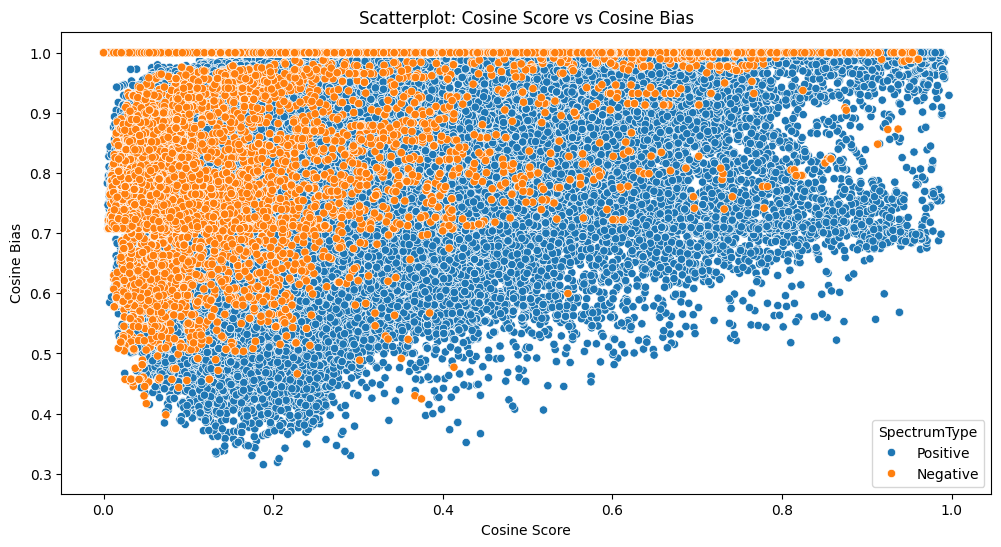

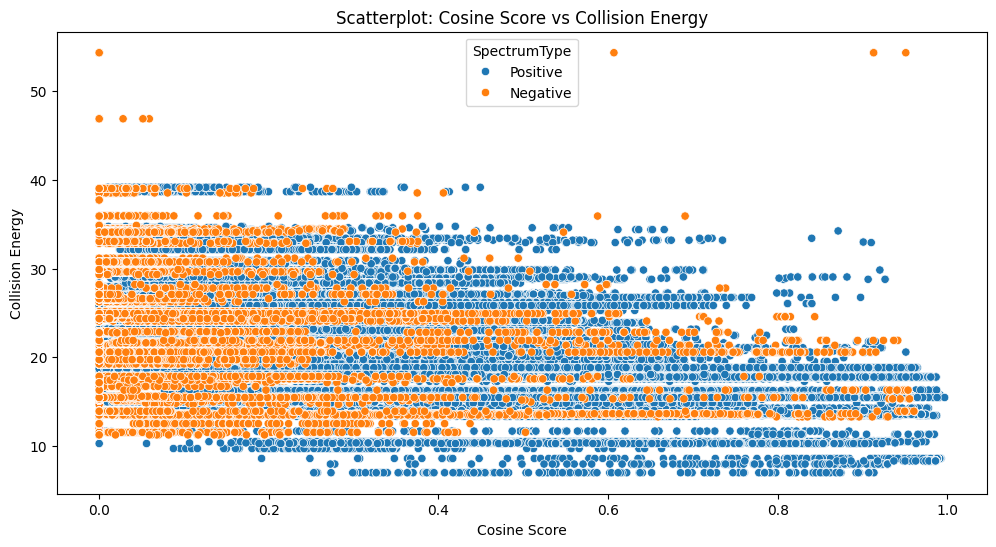

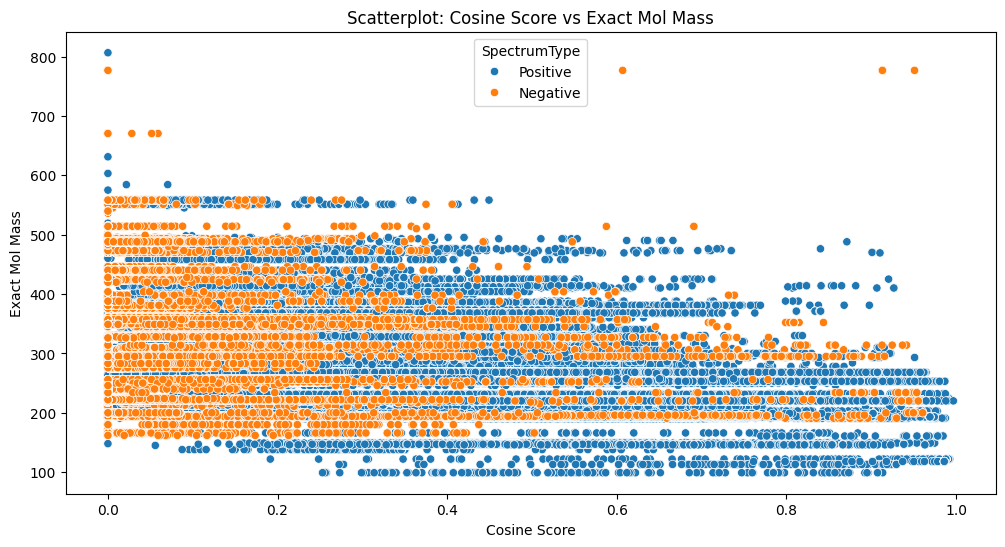

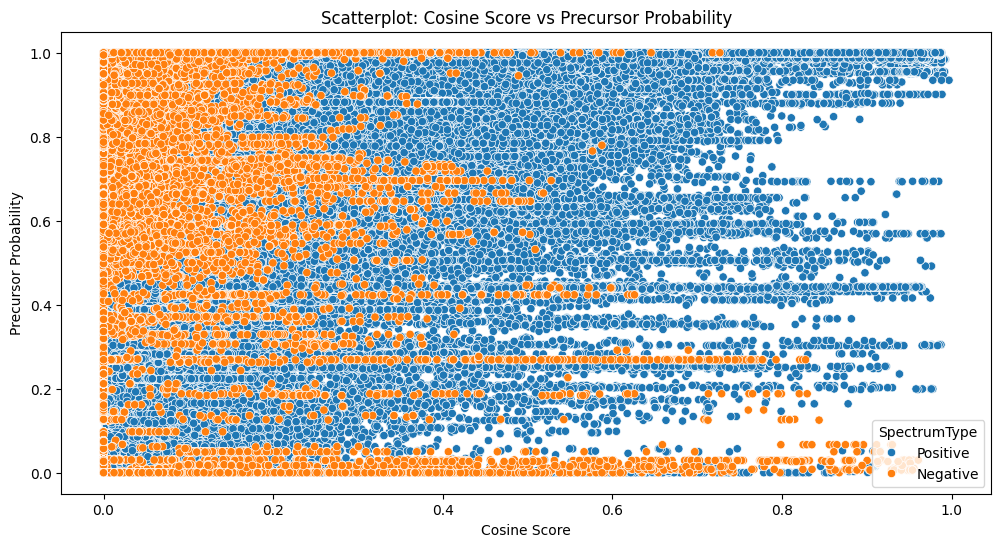

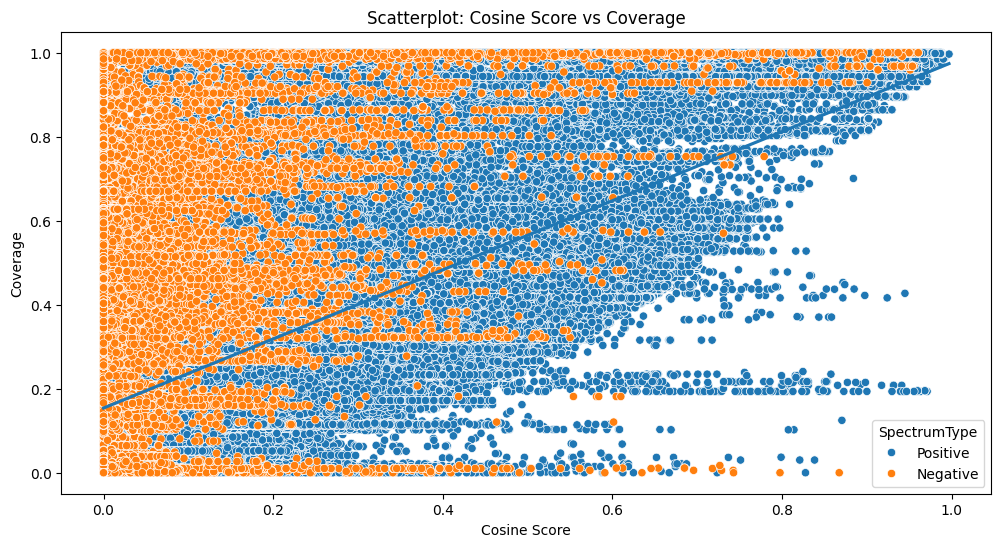

In [28]:
pos_neg_combine_df["CosineBias"] = pos_neg_combine_df["Score"].apply(lambda x: np.nan if x == {} else x["cosine"]["bias"])

# Scatterplot for Cosine Score vs Cosine Bias
plt.figure(figsize=(12, 6))
sns.scatterplot(x="CosineScore", y="CosineBias", hue="SpectrumType", data=pos_neg_combine_df)
plt.xlabel("Cosine Score")
plt.ylabel("Cosine Bias")
plt.title("Scatterplot: Cosine Score vs Cosine Bias")
plt.show()

# Scatterplot for Cosine Score vs Collision Energy
plt.figure(figsize=(12, 6))
sns.scatterplot(x="CosineScore", y="CollisionEnergy", hue="SpectrumType", data=pos_neg_combine_df)
plt.xlabel("Cosine Score")
plt.ylabel("Collision Energy")
plt.title("Scatterplot: Cosine Score vs Collision Energy")
plt.show()

# Scatterplot für Cosine Score vs Exact Mol Mass
plt.figure(figsize=(12, 6))
sns.scatterplot(x="CosineScore", y="ExactMolMass", hue="SpectrumType", data=pos_neg_combine_df)
plt.xlabel("Cosine Score")
plt.ylabel("Exact Mol Mass")
plt.title("Scatterplot: Cosine Score vs Exact Mol Mass")
plt.show()

# Scatterplot für Cosine Score vs Precursor Probability
plt.figure(figsize=(12, 6))
sns.scatterplot(x="CosineScore", y="PrecursorProbability", hue="SpectrumType", data=pos_neg_combine_df)
plt.xlabel("Cosine Score")
plt.ylabel("Precursor Probability")
plt.title("Scatterplot: Cosine Score vs Precursor Probability")
plt.show()

positive_data = pos_neg_combine_df[pos_neg_combine_df["SpectrumType"] == "Positive"]

# Scatterplot für Cosine Score vs Coverage
plt.figure(figsize=(12, 6))
scatter_plot = sns.scatterplot(x="CosineScore", y="Coverage", hue="SpectrumType", data=pos_neg_combine_df)

# add a trendline using sns.regplot()
sns.regplot(x="CosineScore", y="Coverage", data=positive_data, scatter=False, ax=scatter_plot)

plt.xlabel("Cosine Score")
plt.ylabel("Coverage")
plt.title("Scatterplot: Cosine Score vs Coverage")
plt.show()



Vergleich der Cosine Score der Lösungen, Pos vs Neg

In [29]:
solutions_df = pd.read_csv("/home/lbarbut/.vscode-server/data/CASMI_2016/solutions_casmi2016_cat2and3.csv")

# find solution of the relevant challenge through molecule name
pos_neg_combine_df["source"] = "Candidate"
for i, row in solutions_df.iterrows():
    challenge_name = row["ChallengeName"]
    inchikey = row["INCHIKEY"]
    condition = (pos_neg_combine_df["Challenge"] == challenge_name) & (pos_neg_combine_df["InChIKey"] == inchikey)
    pos_neg_combine_df.loc[condition, "source"] = "Solution"

In [30]:
# print solution rows
for i, row in pos_neg_combine_df.iterrows():
    if row["source"] == "Solution":
        print("challenge: " + row["Challenge"] + " compound name: " + row["CompoundName"])

challenge: Challenge-082 compound name: Cyromazine
challenge: Challenge-083 compound name: 4-Dimethylaminopyridine
challenge: Challenge-084 compound name: Creatinine
challenge: Challenge-085 compound name: Benzimidazole
challenge: Challenge-086 compound name: Cyclohexylamine
challenge: Challenge-087 compound name: 2-Nitrobenzamide
challenge: Challenge-088 compound name: Carbendazim
challenge: Challenge-089 compound name: Methyl pyrazinoate
challenge: Challenge-090 compound name: benzimidazole-2-thiol
challenge: Challenge-091 compound name: 5-Acetamido-2-hydroxybenzoic acid
challenge: Challenge-092 compound name: o-Acetotoluide
challenge: Challenge-093 compound name: Terbutylazine-2-hydroxy
challenge: Challenge-094 compound name: 4-[(2-Amino-3,5-dibromobenzyl)amino]cyclohexanol
challenge: Challenge-095 compound name: 5-Phenyl-1H-tetrazole
challenge: Challenge-096 compound name: Captopril
challenge: Challenge-097 compound name: 2-Amino-1-methyl-6-phenylimidazo(4,5-b)pyridine
challenge: C

Calculate Recall

In [31]:
def find_recall(df, k):
    df.sort_values(by="CosineScore", ascending=False, na_position="last", inplace=True)
    top_k_predictions = df.groupby("Challenge").head(k)

    solution_in_top_k = top_k_predictions[top_k_predictions['source'] == "Solution"].groupby("Challenge").size()
    recall_rate = solution_in_top_k.sum() / len(df["Challenge"].dropna().unique())
    
    return recall_rate

# tp = 0
# for c in pos_neg_combine_df["Challenge"].unique():
#     if any(pos_neg_combine_df[pos_neg_combine_df["Challenge"] == c]['source'].head(k) == "Solution"):
#         print(c)
#         tp += 1
# tp / len(pos_neg_combine_df["Challenge"].dropna().unique())

k = 10
recall_rate = find_recall(pos_neg_combine_df, k)

/tmp/ipykernel_2704430/4181056711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="CosineScore", ascending=False, na_position="last", inplace=True)
/tmp/ipykernel_2704430/4181056711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="CosineScore", ascending=False, na_position="last", inplace=True)
/tmp/ipykernel_2704430/4181056711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_value

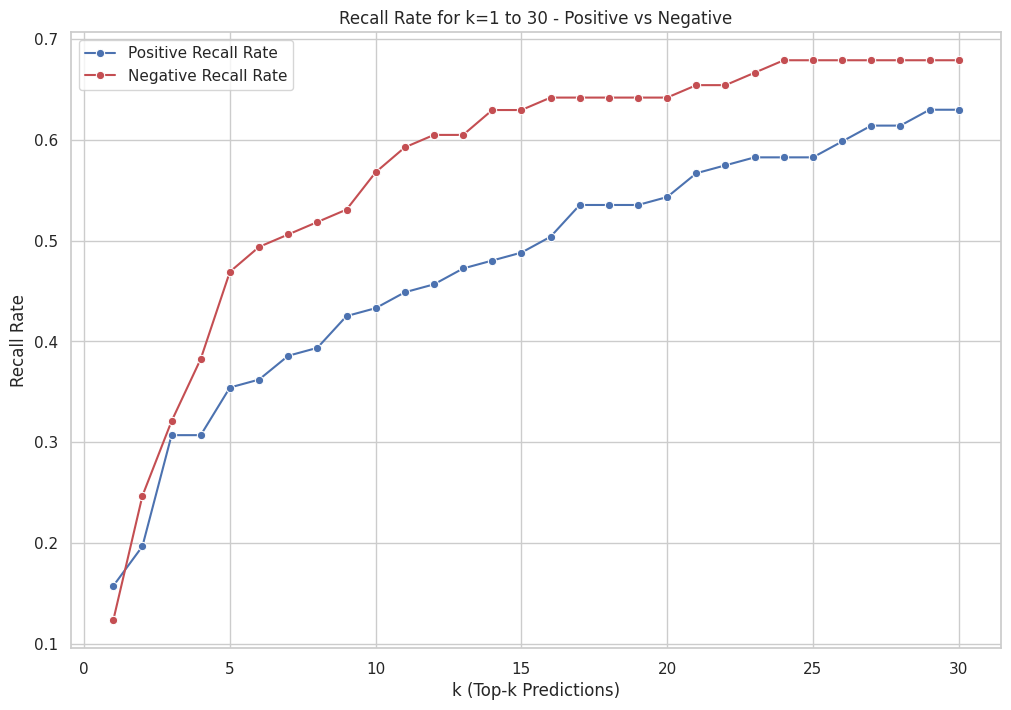

In [32]:
positive_recall_rates = []
negative_recall_rates = []

for k in range(1, 31):
    positive_recall_rate = find_recall(pos_neg_combine_df[pos_neg_combine_df['SpectrumType'] == 'Positive'], k)
    negative_recall_rate = find_recall(pos_neg_combine_df[pos_neg_combine_df['SpectrumType'] == 'Negative'], k)
    
    positive_recall_rates.append(positive_recall_rate)
    negative_recall_rates.append(negative_recall_rate)


sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plotting positive recall rates
sns.lineplot(x=range(1, 31), y=positive_recall_rates, marker='o', color='b', label='Positive Recall Rate')

# Plotting negative recall rates
sns.lineplot(x=range(1, 31), y=negative_recall_rates, marker='o', color='r', label='Negative Recall Rate')

# Adding labels and title
plt.title('Recall Rate for k=1 to 30 - Positive vs Negative')
plt.xlabel('k (Top-k Predictions)')
plt.ylabel('Recall Rate')

# Display the legend
plt.legend()

# Display the plot
plt.show()

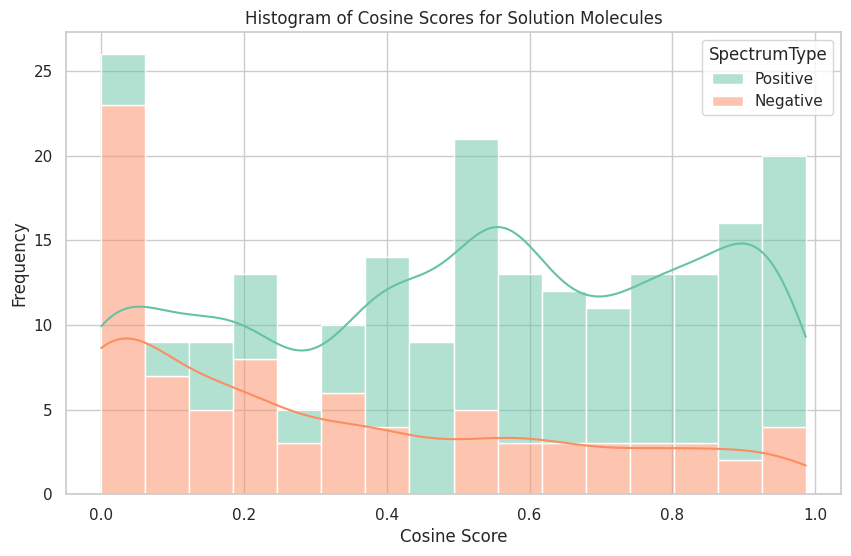

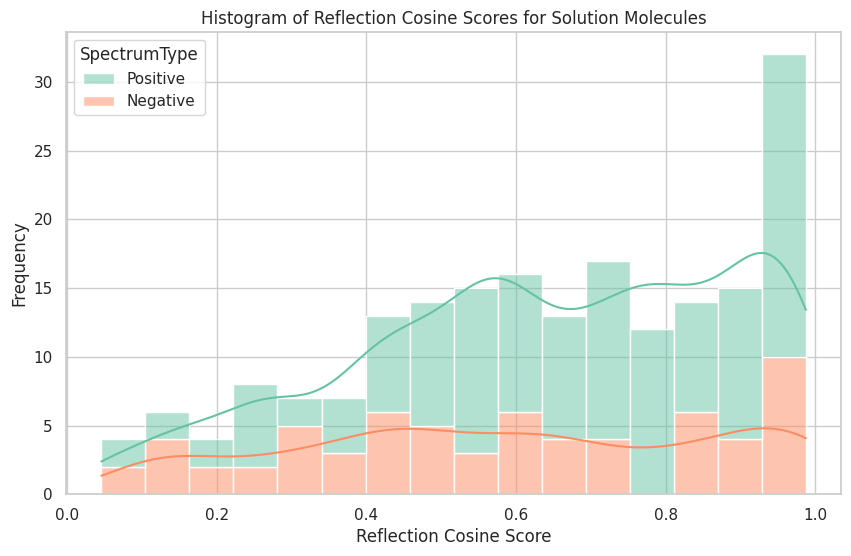

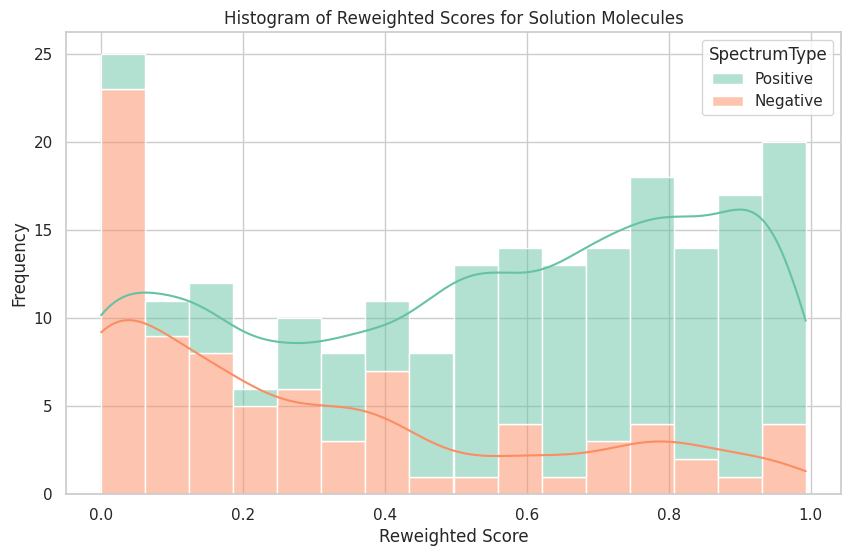

In [33]:
# Filter rows where the source is 'Solution'
solution_df = pos_neg_combine_df[(pos_neg_combine_df['source'] == 'Solution') & (~pos_neg_combine_df['CosineScore'].isna())]

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=solution_df, x='CosineScore', bins=16, kde=True, kde_kws={'bw_adjust': 0.6}, hue='SpectrumType', multiple='stack', palette='Set2')
plt.xlabel('Cosine Score')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Scores for Solution Molecules')
# plt.legend(title='Spectrum Type', loc="upper left", markerscale=2)
plt.show()

# for other Scores
plt.figure(figsize=(10, 6))
sns.histplot(data=solution_df, x='ReflCosineScore', bins=16, kde=True, kde_kws={'bw_adjust': 0.6}, hue='SpectrumType', multiple='stack', palette='Set2')
plt.xlabel('Reflection Cosine Score')
plt.ylabel('Frequency')
plt.title('Histogram of Reflection Cosine Scores for Solution Molecules')
# plt.legend(title='Spectrum Type', loc="upper left", markerscale=2)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=solution_df, x='ReweightedScore', bins=16, kde=True, kde_kws={'bw_adjust': 0.6}, hue='SpectrumType', multiple='stack', palette='Set2')
plt.xlabel('Reweighted Score')
plt.ylabel('Frequency')
plt.title('Histogram of Reweighted Scores for Solution Molecules')
# plt.legend(title='Spectrum Type', loc="upper left", markerscale=2)
plt.show()


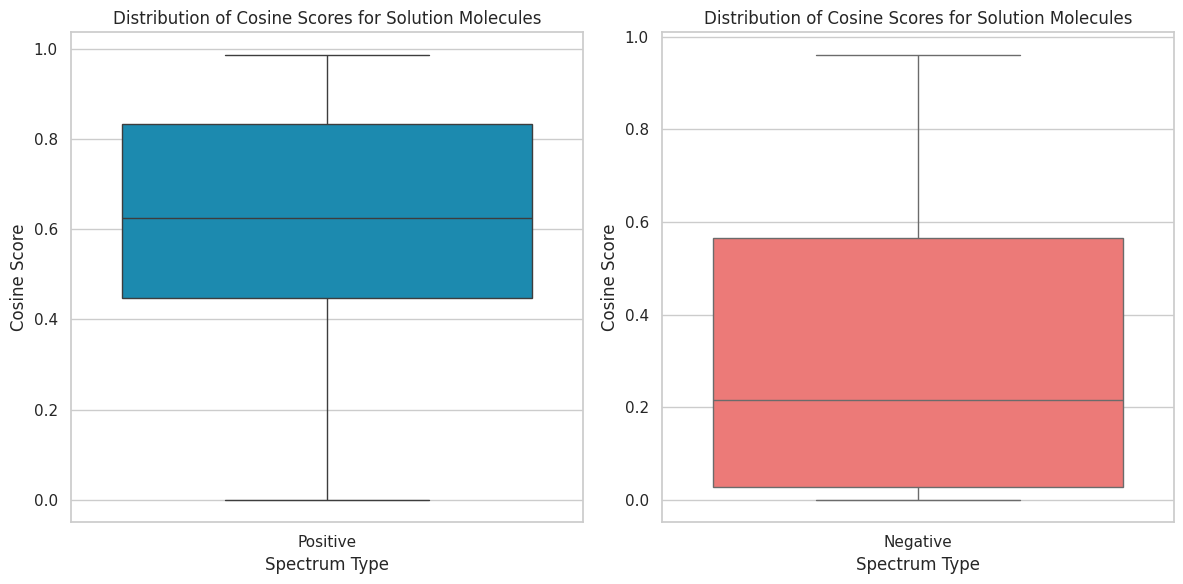

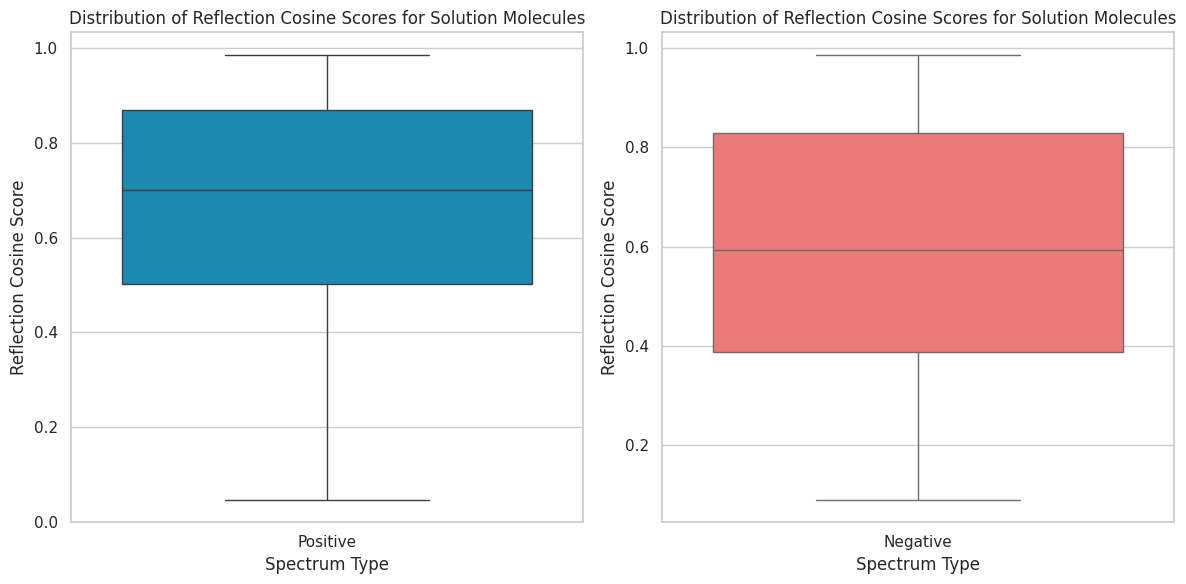

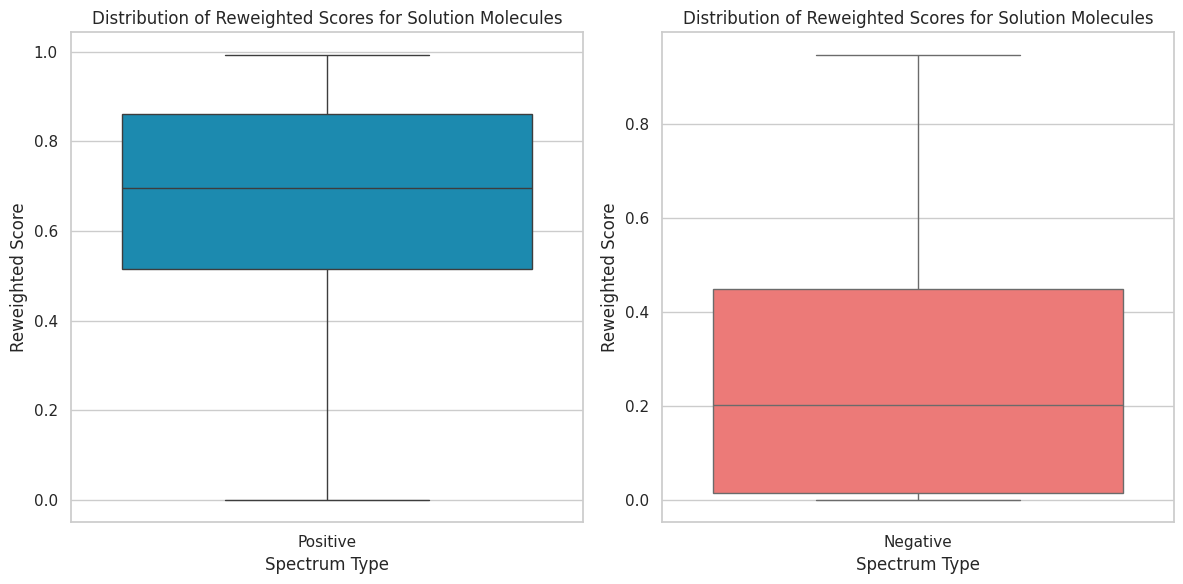

In [34]:
# Boxplot
plt.figure(figsize=(12, 6))

# Boxplot for positive spectra
plt.subplot(1, 2, 1)
sns.boxplot(x="SpectrumType", y="CosineScore", data=solution_df[solution_df["SpectrumType"] == "Positive"], color = "#0496C7")
plt.title("Distribution of Cosine Scores for Solution Molecules")
plt.xlabel("Spectrum Type")
plt.ylabel("Cosine Score")

# Boxplot for negative spectra
plt.subplot(1, 2, 2)
sns.boxplot(x="SpectrumType", y="CosineScore", data=solution_df[solution_df["SpectrumType"] == "Negative"], color = "#FF6865")
plt.title("Distribution of Cosine Scores for Solution Molecules")
plt.xlabel("Spectrum Type")
plt.ylabel("Cosine Score")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# for other Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x="SpectrumType", y="ReflCosineScore", data=solution_df[solution_df["SpectrumType"] == "Positive"], color = "#0496C7")
plt.title("Distribution of Reflection Cosine Scores for Solution Molecules")
plt.xlabel("Spectrum Type")
plt.ylabel("Reflection Cosine Score")

plt.subplot(1, 2, 2)
sns.boxplot(x="SpectrumType", y="ReflCosineScore", data=solution_df[solution_df["SpectrumType"] == "Negative"], color = "#FF6865")
plt.title("Distribution of Reflection Cosine Scores for Solution Molecules")
plt.xlabel("Spectrum Type")
plt.ylabel("Reflection Cosine Score")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x="SpectrumType", y="ReweightedScore", data=solution_df[solution_df["SpectrumType"] == "Positive"], color = "#0496C7")
plt.title("Distribution of Reweighted Scores for Solution Molecules")
plt.xlabel("Spectrum Type")
plt.ylabel("Reweighted Score")

plt.subplot(1, 2, 2)
sns.boxplot(x="SpectrumType", y="ReweightedScore", data=solution_df[solution_df["SpectrumType"] == "Negative"], color = "#FF6865")
plt.title("Distribution of Reweighted Scores for Solution Molecules")
plt.xlabel("Spectrum Type")
plt.ylabel("Reweighted Score")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Solutions vs Candidates Cosine Score Histogram, Boxplot

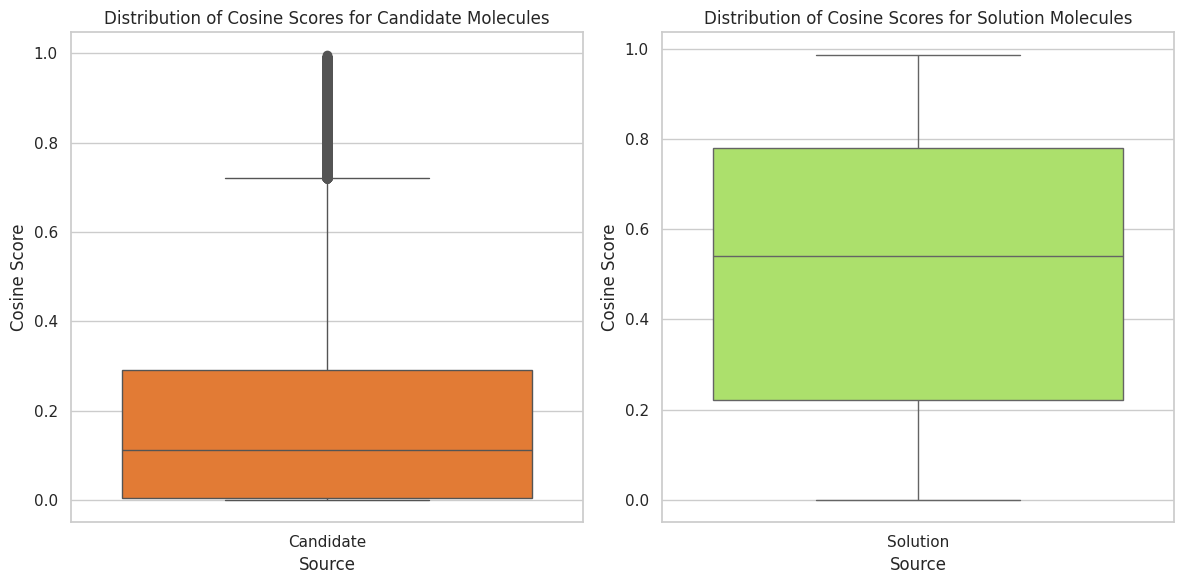

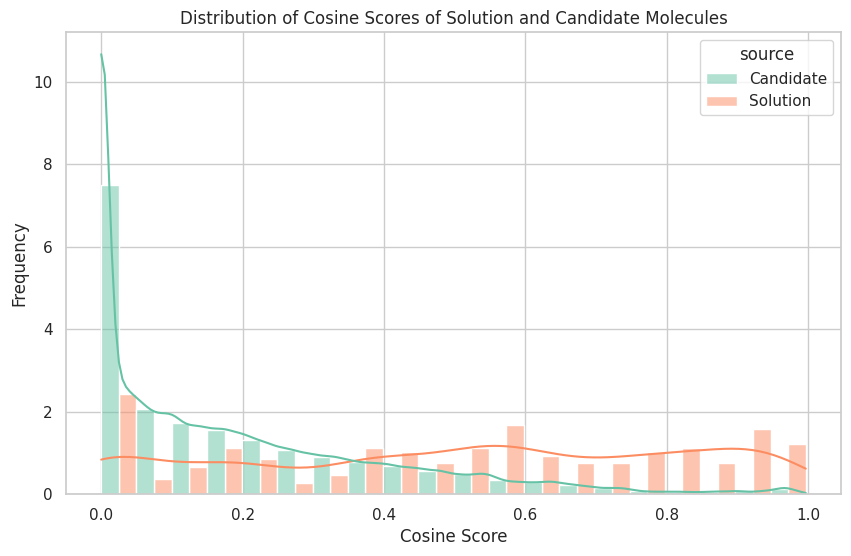

In [35]:
# Boxplot
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.boxplot(x="source", y = "CosineScore", data=pos_neg_combine_df[pos_neg_combine_df["source"] == "Candidate"], color="#FF7518")
plt.title("Distribution of Cosine Scores for Candidate Molecules")
plt.xlabel("Source")
plt.ylabel("Cosine Score")

plt.subplot(1, 2, 2)
sns.boxplot(x="source", y = "CosineScore", data=pos_neg_combine_df[pos_neg_combine_df["source"] == "Solution"], color="#AEF359")
plt.title("Distribution of Cosine Scores for Solution Molecules")
plt.xlabel("Source")
plt.ylabel("Cosine Score")

plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(10,6))
sns.histplot(data=pos_neg_combine_df, x='CosineScore', bins=20, kde=True, kde_kws={'bw_adjust': 0.6}, stat="density", common_norm=False, hue='source', multiple='dodge', palette='Set2')
plt.xlabel('Cosine Score')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Scores of Solution and Candidate Molecules')
plt.show()